# Build a Real-Time Stock Price Dashboard Web App
Estimated time needed: 60 minutes

# Objectives

After completing this lab, you will be able to:

- Use the Python libraries and tools for financial data analysis, including `yfinance` and `cufflinks`.
- Create interactive visualizations to gain insights into stock performance and portfolio management.
- Calculate and visualize cumulative returns for a weighted portfolio of multiple stocks in the semiconductor industry.
- Use open-source framework, `Mercury`, to share the exciting outcomes of your stock data analysis as an interactive web application with a global audience.



IBM has a special offer for watsonx.ai, a studio for new foundation models, generative AI and machine learning. To take advantage of this offer visit
<a href="https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=data_science_experience,watson_data_platform,cos
">watsonx.ai homepage</a>


Now, let's dive into the project step by step.


## Understanding Mercury
### 1. What is Mercury?
Mercury is an open-source(opens in a new tab) framework that helps you build web applications from your Jupyter Notebooks. It's built using technologies like Django, Django Channels, and React. Imagine it as a bridge between our notebooks and the web browser. When a user opens a notebook in a web browser, Mercury Server steps in and establishes a connection, much like a virtual highway, between the browser and itself. 

### 2. How It Works:

- **WebSocket Connection:** This connection is established between the user's web browser and Mercury Server. It's like a live channel of communication that lets data flow back and forth seamlessly.
- **Mercury Server and Worker:** Mercury Server ensures there's a "worker" ready to handle requests. Think of this worker as a skilled assistant. It connects to Mercury Server via WebSocket.
- **Action Forwarding:** When a user interacts with the app in their browser, every action they take is forwarded by Mercury Server to the worker. It's like passing notes between them.

- **Kernel Magic:** The worker maintains an open IPython kernel and understands the code from our notebook. It's our app's brain. When users interact with widgets, the worker's kernel executes the code related to those interactions.

- **Results Flow:** The worker sends the results of these executions back to the user's browser through Mercury Server. Imagine getting a quick answer after asking a question.

### 3. Why Mercury?
Mercury is the simplest way to transform our notebooks into web apps. It offers great features:
- You can show or hide your code easily.
- Your users can easily export executed notebook to PDF/HTML.
- You can produce files in the notebook and make them downloadable.
- You can share multiple notebooks with Mercury Cloud.


---


# Step 1: Setup


For this lab, we will be using the following libraries:

* `yfinance`: for fetching financial data from Yahoo Finance.
* `ipyvuetify`: for creating interactive web-based user interfaces with Vuetify components.
* `cufflinks`: for simplifying data visualization and charting when working with `Pandas` DataFrames in conjunction with `Plotly`.
* `mercury`: for converting the notebook into a web app.


### Installing Required Libraries


In [1]:
!pip install yfinance ipyvuetify cufflinks  mercury

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 81.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 80.3 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [2]:
import pandas as pd
import cufflinks as cf
cf.go_offline() # Configure Plotly to work in offline mode
import numpy as np
import yfinance as yf
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import mercury as mr
from dateutil.relativedelta import relativedelta

---


# Step 2: Configure the Mercury App
In this step, we will instantiate a Mercury app by providing it a title and description. <font color="red">It's important to note that, although the output can't be displayed directly within the notebook, we use input widgets to define dynamic variables that will be used later in the app. These widgets allow users to interact with the app and customize their experience. 


In [3]:
app = mr.App(title="📈 Stock Price Dashboard", description="Dashboard with financial data", show_code=False)

mercury.App

Next, we create input widgets to capture user choices:

- ticker: This widget presents a selection of available stock tickers (e.g., NVDA, INTC, AMD, TSM, MU) for users to choose from. The selected ticker will be used for data analysis.
- period: Users can specify the number of past months (e.g., 3 months) of stock data they want to analyze. This numeric input allows a range from 1 to 12 months.

## Selecting Your Preferred Stock
Before advancing, take a moment to customize your stock selection based on your interests. While the tutorial initially showcases semiconductor stocks for demonstration purposes, you can simply replace 'NVDA', 'INTC', 'AMD', 'TSM', 'MU' with your preferred stock symbol to align with your specific area of interest and analysis goals.


In [4]:
ticker = mr.Select(label="Please select ticker", value='NVDA', 
                   choices=['NVDA', 'INTC', 'AMD', 'TSM', 'MU'])

mercury.Select

In [5]:
mr.Md(f"# Selected ticker: {ticker.value}")

# Selected ticker: NVDA

## Customizing the Time Period
You can also customize the time period for data analysis. The default period is set to 3 months, but you can modify it to suit your needs.


In [6]:
period = mr.Numeric(label="Past Month(s)", value=3, min=1, max=12)

mercury.Numeric

---


# Step 3: Visualize Stock Performance 
## Downloading and Visualizing Selected Stock Data
After configuring the app, we proceed to download the stock data for the selected ticker (e.g., NVDA) and the specified time period (e.g., 3 months). The downloaded data, in this case, represents NVIDIA Corporation (NVDA) stock data for analysis. We display the first few rows of this data to provide users with an initial glimpse of the dataset.

Please note that the actual interactivity and visualization of the data will be showcased within the Mercury app, but the initial data download and setup are illustrated here.


In [7]:
# Download NVIDIA Corporation (NVDA) stock data for analysis
stock_data = yf.download(ticker.value, start=date.today() - relativedelta(months=+period.value), end=date.today())
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-08-01,464.600006,469.000000,460.269989,465.070007,465.031708,23785800
2023-08-02,458.309998,458.399994,433.869995,442.690002,442.653534,53014200
2023-08-03,438.000000,451.179993,438.000000,445.149994,445.113312,32417600
2023-08-04,449.850006,456.420013,443.929993,446.799988,446.763184,36225800
2023-08-07,451.109985,455.399994,445.630005,454.170013,454.132599,32215400
...,...,...,...,...,...,...
2023-10-25,433.980011,436.500000,415.549988,417.790009,417.790009,39837900
2023-10-26,418.529999,422.559998,398.799988,403.260010,403.260010,54100100
2023-10-27,411.299988,412.059998,400.149994,405.000000,405.000000,41602900


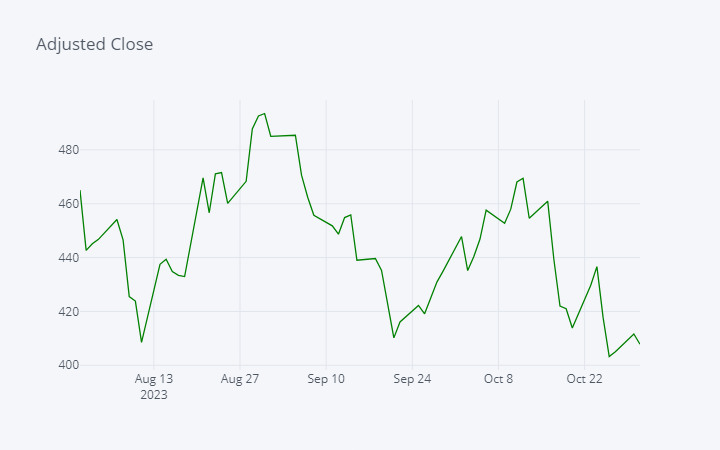

In [8]:
# Create and display an interactive line plot of NVDA's Adjusted Close Prices
stock_data['Adj Close'].iplot(title='Adjusted Close', colors=['green'])

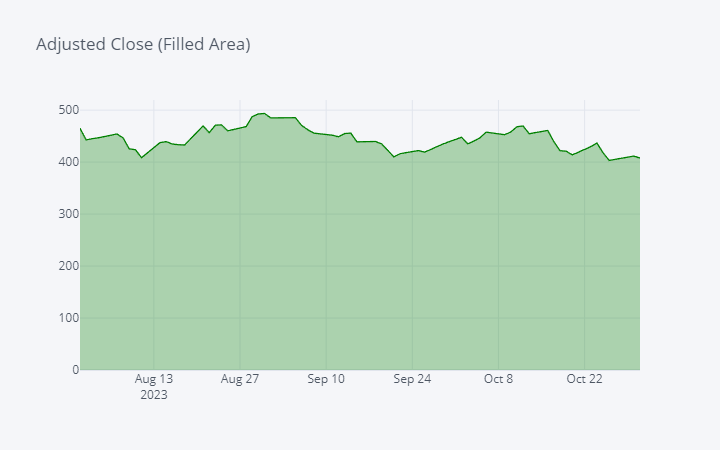

In [9]:
# Create and display an interactive filled area plot of NVDA's Adjusted Close Prices
stock_data['Adj Close'].iplot(title='Adjusted Close (Filled Area)', fill=True, colors=['green'])

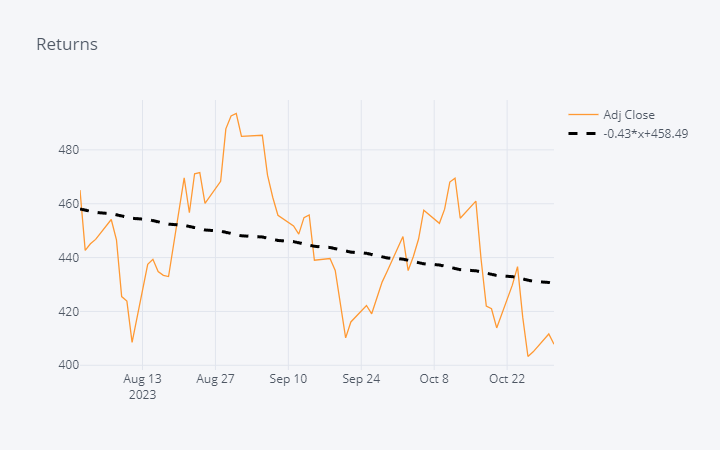

In [10]:
# Create and display an interactive line plot of NVDA's Returns with a best-fit line
stock_data['Adj Close'].iplot(title='Returns', bestfit=True, bestfit_colors=['black'])

## Quantitative Analysis with QuantFig
We'll perform quantitative analysis using the `QuantFig` class from `cufflinks`, adding technical indicators and volume data to gain deeper insights.


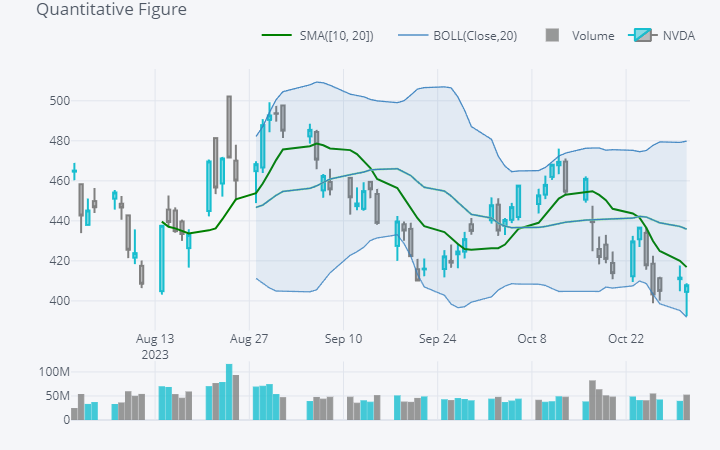

In [11]:
# Create a Quantitative Figure (QuantFig) for the NVDA stock data
qf = cf.QuantFig(stock_data, title='Quantitative Figure', legend='top', name=ticker.value)
qf.add_sma([10, 20], width=2, color=['green', 'lightgreen'], legendgroup=True)
qf.add_bollinger_bands()
qf.add_volume()
qf.iplot()

# Comparing Semiconductor Companies
Next, we will download and compare historical stock data for multiple semiconductor companies.


In [12]:
# Download stock data for semiconductor companies
semiconductor_tickers = ['NVDA', 'INTC', 'AMD', 'TSM', 'MU']
semiconductor_data = yf.download(semiconductor_tickers, start=date.today() - relativedelta(months=+period.value), end=date.today())
semiconductor_data

[*********************100%%**********************]  5 of 5 completed


Adj Close                                               \
                   AMD       INTC         MU        NVDA        TSM   
Date                                                                  
2023-08-01  117.599998  35.671665  70.642151  465.031708  97.891930   
2023-08-02  109.349998  34.266720  68.056465  442.653534  95.205872   
2023-08-03  113.150002  34.744999  69.064781  445.113312  94.489594   
2023-08-04  115.820000  35.139999  69.793571  446.763184  95.663498   
2023-08-07  116.809998  35.230000  69.264450  454.132599  95.852516   
...                ...        ...        ...         ...        ...   
2023-10-25   96.059998  32.830002  66.500000  417.790009  87.639999   
2023-10-26   93.669998  32.520000  64.529999  403.260010  87.449997   
2023-10-27   96.430000  35.540001  65.650002  405.000000  85.989998   
2023-10-30   96.180000  35.689999  66.070000  411.609985  86.059998   
2023-10-31   98.500000  36.500000  66.870003  407.799988  86.309998   

                 Close                                               ...  \
                   AMD       INTC         MU        NVDA        TSM  ...   
Date                                                                 ...   
2023-08-01  117.599998  35.799999  70.760002  465.070007  98.400002  ...   
2023-08-02  109.349998  34.389999  68.169998  442.690002  95.699997  ...   
2023-08-03  113.150002  34.869999  69.180000  445.149994  94.980003  ...   
2023-08-04  115.820000  35.139999  69.910004  446.799988  96.160004  ...   
2023-08-07  116.809998  35.230000  69.379997  454.170013  96.349998  ...   
...                ...        ...        ...         ...        ...  ...   
2023-10-25   96.059998  32.830002  66.500000  417.790009  87.639999  ...   
2023-10-26   93.669998  32.520000  64.529999  403.260010  87.449997  ...   
2023-10-27   96.430000  35.540001  65.650002  405.000000  85.989998  ...   
2023-10-30   96.180000  35.689999  66.070000  411.609985  86.059998  ...   
2023-10-31   98.500000  36.500000  66.870003  407.799988  86.309998  ...   

                  Open                                               \
                   AMD       INTC         MU        NVDA        TSM   
Date                                                                  
2023-08-01  114.260002  35.820000  71.000000  464.600006  99.139999   
2023-08-02  119.489998  35.150002  69.750000  458.309998  97.500000   
2023-08-03  108.949997  34.290001  67.570000  438.000000  94.839996   
2023-08-04  114.480003  34.480000  69.500000  449.850006  95.279999   
2023-08-07  116.360001  35.410000  69.849998  451.109985  96.730003   
...                ...        ...        ...         ...        ...   
2023-10-25  100.419998  34.180000  68.489998  433.980011  90.800003   
2023-10-26   95.989998  32.889999  66.449997  418.529999  87.120003   
2023-10-27   95.800003  34.660000  64.919998  411.299988  87.540001   
2023-10-30   96.139999  35.470001  66.360001  410.869995  87.309998   
2023-10-31   96.239998  35.660000  66.080002  404.500000  86.150002   

               Volume                                          
                  AMD      INTC        MU      NVDA       TSM  
Date                                                           
2023-08-01   95279300  24702200  13141100  23785800   6428500  
2023-08-02  173372000  39052000  14004400  53014200   9820900  
2023-08-03   90605400  24817900  11075200  32417600   8571700  
2023-08-04   83083100  26664300  11250200  36225800   7559000  
2023-08-07   65854800  22486900  10537500  32215400   6601400  
...               ...       ...       ...       ...       ...  
2023-10-25   53424500  44658500  11924300  39837900  13027100  
2023-10-26   49896400  59142500  16697900  54100100   9377300  
2023-10-27   52428300  84062000   9978200  41602900  12478300  
2023-10-30   43716600  36656300  10667700  38802800   9785500  
2023-10-31   78433800  41150900   8247100  51696500   9001300  

[65 rows x 30 columns]

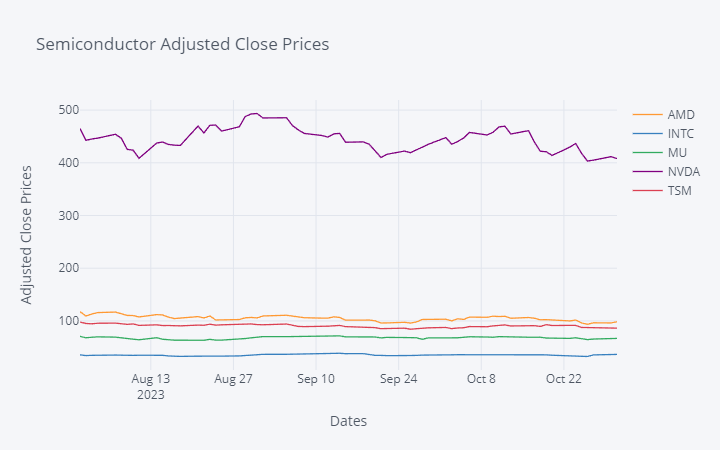

In [13]:
# Create and display an interactive line plot of Adjusted Close Prices for semiconductor companies
semiconductor_data['Adj Close'].iplot(title='Semiconductor Adjusted Close Prices', xTitle='Dates', yTitle='Adjusted Close Prices')

# Calculating Cumulative Returns
Finally, we'll calculate and visualize cumulative returns for a weighted portfolio of semiconductor stocks. You can define your own portfolio weights based on your investment strategy.


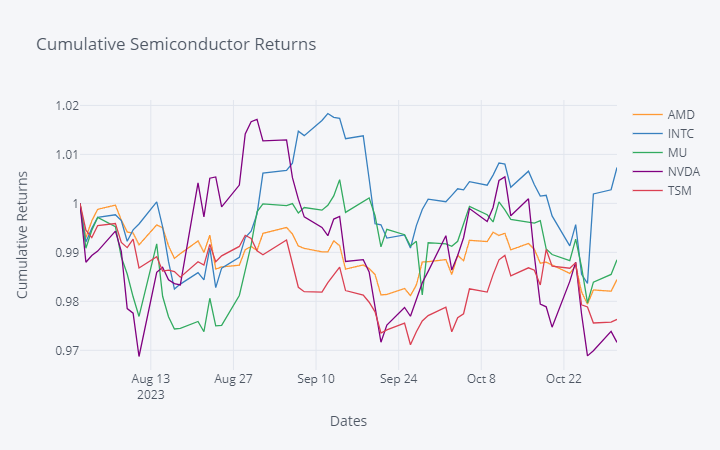

In [14]:
semiconductor_returns = semiconductor_data['Adj Close'].pct_change() # Calculate daily returns for each company
semiconductor_returns.iloc[0, :] = 0 # Set the initial value of returns to 0 (first day)
weights = np.array([0.1, 0.2, 0.25, 0.25, 0.2]) # Define the weights for each company in the portfolio; You can flexibly adjust these weights as needed
weighted_returns = weights * semiconductor_returns # Calculate the weighted returns for each company
cumulative_returns = (weighted_returns + 1).cumprod() # Calculate cumulative returns for the portfolio
cumulative_returns.iplot(title='Cumulative Semiconductor Returns', xTitle='Dates', yTitle='Cumulative Returns')

# Step 3: Deploy the Notebook as a Web App Using Mercury

The last crucial phase involves deploying our model as an interactive web application utilizing the open-source Mercury framework. With just a few clicks, you can harness its cloud capabilities to present your work to a wider audience! Later you will be asked to remove all images and cleared any Markdown cells and image tags. We've already taken care if you not sure just use the following file:



#### **Demo: [here](https://ibm-demo.runmercury.com/app/demo-6)**


## Step 3-1: Prepare the Notebook
1. Look for the **"Download Notebook"** button at the top of the notebook's toolbar to download the notebook.
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-07%20at%2010.53.04%20PM.png">
2. Once you've downloaded the notebook, you can remove the code or Markdown cells from the download file to not display those on the web. 

3. We can download  the   ```requirements.txt``` to our cloud environment, the file is used to specify the dependencies and their versions for a project. This file is commonly used with package management tools like pip to install the required packages for your project


In [15]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/requirements.txt

--2023-11-01 19:27:48--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/requirements.txt
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      49  --.-KB/s    in 0s      

2023-11-01 19:27:48 (22.8 MB/s) - ‘requirements.txt’ saved [49/49]



4) Then download it to your local computer using the left tool bar

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-08%20at%205.47.24%20PM.png">




#### **You can refer to [the Notebook we demo on Mercury](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/demo.ipynb)** 

## Step 3-2: Setup a Mercury Account
1. Sign up for a free account at [Mercury](https://cloud.runmercury.com/register).
2. After signing up, log in to your Mercury account.

## Step 3-3: Create Your First Site
1. Look for the green **"+ Add Site"** button and click it.
2. In the **"Title of your website"** field, enter `Stock Price Viz`.
3. In the "Subdomain at which website will be available" field, enter `demo`(Please note that site subdomain names must be unique. In case the chosen subdomain name is already taken, be prepared to modify it accordingly).
4. Click the green **"OK"** button at the bottom of the page.

## Step 3-4: Upload Your File
1. Click the **"Upload Files"** button on the right side of the site you just created.
2. Upload your downloaded `ipynb` notebook from Step 3-1 into your new site. 
3. Upload ```requirements.txt```
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0OECEN/Screenshot%202023-09-07%20at%2010.05.55%20PM.png">

## Step 3-5: Open the App
1. Return to the sites menu by clicking the **"[Sites](https://cloud.runmercury.com/sites)"** button on the top navigation bar.
2. Click the link associated with the `Stock Price Viz` site.
3. You need to wait for approximately 10 minutes to allow Mercury to display your Jupyter Notebook after opening the file.
4. Voilà! You've successfully accessed your site where you can explore and interact with your uploaded notebook.

<font color="red">**Note: For some reasons, we found that we need to make modifications to the Jupyter Notebook if the Notebook doesn't display smoothly on Mercury. This includes actions like deleting a code cell and then re-uploading it again to display the Jupyter Notebook.**


---


# Congratulations! You have completed the lab


## Authors


[Vicky Kuo](https://author.skills.network/instructors/vicky_kuo)


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-09-01|0.1|Vicky Kuo|Initial Lab Created|


Copyright © 2023 IBM Corporation. All rights reserved.
